# Exploring Source Data

The purpose of this notebook is to investigate a single source file to determine what is necessary for initialization and eventually, artifact rejection.

For instructive purposes, this notebook may be run in various orders to demonstrate how the functions behave.

The browser backend call below is a secondary type of import that allows for interactive and responsive figures.

In [1]:
import matplotlib
matplotlib.use('Agg')
import mne
mne.viz.set_browser_backend('matplotlib') # Use the fancier figures when possible

Using qt as 2D backend.


In the following code cell the variable `subject_file` is being used to point to a BDF file in the `sourcedata` directory.

**NOTE:** The mne function `read_raw` will infer the EEG file format you are using implicitly.

For exploring your own data, change `IC_trn_1.bdf` to your own file.

In [3]:
subject_file = '../data/eeg-study-template/sourcedata/IC_trn_1.bdf' # See description above
raw = mne.io.read_raw(subject_file, preload=True) # Load the defined subject
raw # Last variable in a cell "spills" to the output

Extracting EDF parameters from /media/tyler/PathstoneProject/EEGStudyFlow/sourcedata/IC_trn_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 280575  =      0.000 ...   273.999 secs...


<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.2 MiB, data loaded>

This stage should be used to confirm that the above cell has printed out what you expect from your data.

Some import thinks to check that should match expectations:

* Sampling rate
* Duration
* Channel count
* Stim channel

However in the case of the sample data, there are some things that need to be fixed:

* Filtering: the lowpass cell shows 268hz, typically is lower
* Montage: cell shows missing channel information
* Reference: reference explicitly set

Filtering is easily done via the following code block. Change `l_freq` and `h_freq` to suit your needs. If you are interested in a notch filter, an example is provided in the same cell, just commented out.

In [4]:
raw = raw.filter(l_freq=1.0, h_freq=30.0)
# raw = raw.notch_filter(60) # Filter out power line frequency

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s


Next, we can tackle montages. MNE as a rule supports several different builtin montages that you can load without having to provide a file defining channel locations.

They can be viewed as follows:

In [5]:
mne.channels.get_builtin_montages()

['standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'biosemi16',
 'biosemi32',
 'biosemi64',
 'biosemi128',
 'biosemi160',
 'biosemi256',
 'easycap-M1',
 'easycap-M10',
 'easycap-M43',
 'EGI_256',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'mgh60',
 'mgh70',
 'artinis-octamon',
 'artinis-brite23',
 'brainproducts-RNP-BA-128']

If your data happens to be recorded using one of these, you can simply set the montage as in the cell below. The `raw.plot_sensors()` call is used to make sure that all location match the placement scheme visually.

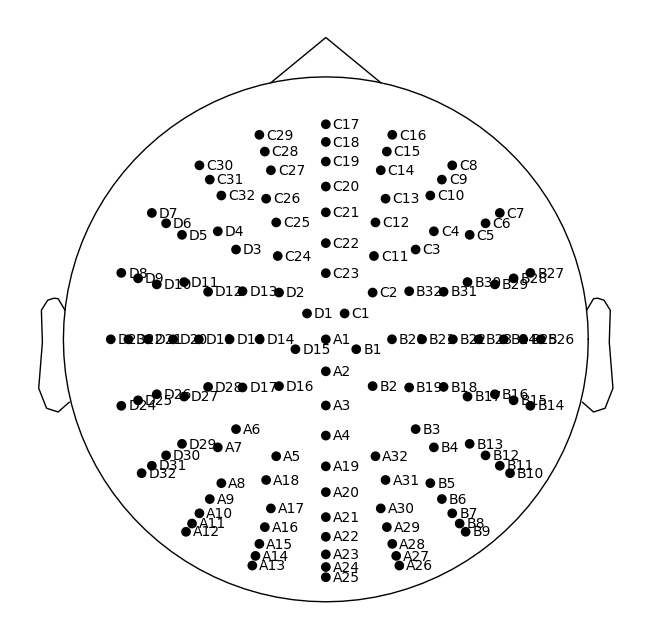

In [6]:
%matplotlib inline
# "magic" cell command, this one keeps the plots in the notebook instead of popping up
raw = raw.set_montage('biosemi128')
_ = raw.plot_sensors(show_names=True)

If your recording montage does not necessarily fit into one of the standards here are some suggestions with code snippets:

* If you have EOG channels, make sure to set their type to `eog` via `raw.set_channel_types` which is documented [here](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_channel_types)
* If there a channels you will not be able to provide information for, or would like to ignore, you can change the behaviour of set montage with the `on_missing` paramater documented [here](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_montage)
  * There are also parameters for matching upper/lower case. Some machines record things as `FPZ`, `fpz`, `FPz`, etc.
* If you have your own specific scheme you would like to load from a file, please see the below code snippet. This assumes that the file is in the same directory as the notebook.

```python
custom_montage = mne.channels.read_custom_montage('custom_montage.elp')
raw = raw.set_montage(custom_montage)
```

Lastly, setting the reference can be quite simple. Below the recording is set to the average reference. In the same code cell are other common reference approaches that can be switched in for another data set.

In [7]:
raw = raw.set_eeg_reference('average')

# use a single channel reference (left earlobe)
# raw = raw.set_eeg_reference(ref_channels=['A1'])

# use average of mastoid channels as reference
# raw = raw.set_eeg_reference(ref_channels=['M1', 'M2']) # Make sure these exist in your montage!!

# use a bipolar reference (contralateral)
# raw.set_bipolar_reference(anode='[F3'], cathode=['F4']) # Make sure these exist in your montage!!

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


At this point, the data is ready for visual inspection to make sure there are not numerous artifacts, or other issues present.

This can be done by the following:

* Checking what MNE understands of the recording in the `raw` variable
* Calculating and viewing the power spectral density to make sure known properties exist
* Plotting the actual scalp data and looking for problems

Starting with the raw object:

In [8]:
raw

<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.3 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


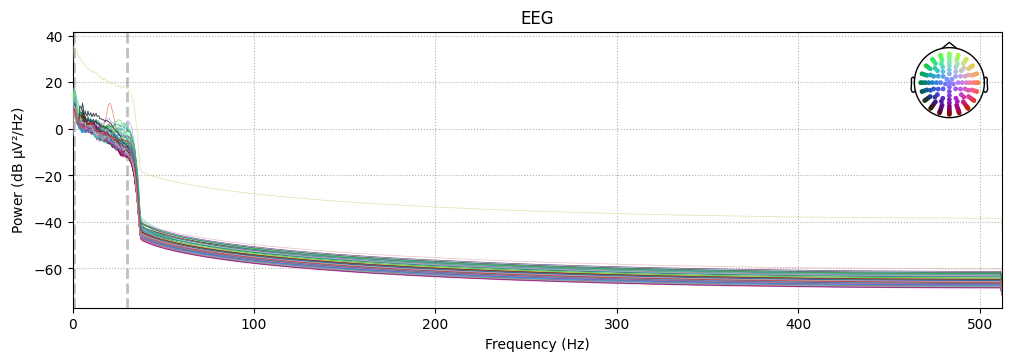

In [9]:
%matplotlib inline
raw.plot_psd() # Computes the psd implicitly

This plot helpfully reveals that `C10` is going to be problematic in the future.

In [ ]:
%matplotlib inline
raw.plot()

We can confirm now via the scrollplot that `C10` is indeed bad. This can be marked as bad inside of the scrollplot or manually set as bad during other steps in preprocessing.

This concludes preparing the data for inspection, and allows a researcher to make decisions about the quality of the recording.

Subsequent sections of this notebook are spent epoching, and briefly cleaning the data to confirm that the subject was attending to the experiment.

### Exploring Epochs

There are two ways that MNE can extract events from files. Either via dedicated stim channels, or "annotations".

This example describes stim channels. As such, the `event_dict` must be manually input. These are your standard pin/markers.

In [10]:
# event_dict = {"boundary": 65791, "anim/house/upright/f1": 11, "anim/house/upright/f2": 12, "anim/house/upright/f3": 13, "anim/house/upright/f4": 14, "anim/house/upright/f5": 15, "anim/house/upright/f6": 16, "anim/face/upright/f1": 31, "anim/face/upright/f2": 32, "anim/face/upright/f3": 33, "anim/face/upright/f4": 34, "anim/face/upright/f5": 35, "anim/face/upright/f6": 36, "house/inverted/f1": 21, "anim/house/inverted/f2": 22, "anim/house/inverted/f3": 23, "anim/house/inverted/f4": 24, "anim/house/inverted/f5": 25, "anim/house/inverted/f6": 26, "anim/checker/f1": 51, "anim/checker/f2": 52, "anim/checker/f3": 53, "anim/checker/f4": 54, "anim/checker/f5": 55, "anim/checker/f6": 56, "anim/face/inverted/f1": 41, "anim/face/inverted/f2": 42, "anim/face/inverted/f3": 43, "anim/face/inverted/f4": 44, "anim/face/inverted/f5": 45, "anim/face/inverted/f6": 46, "static/checker/left": 215, "press/left": 201, "static/checker/right": 216, "press/right": 204, "static/face/upright": 211, "static/face/inverted": 212, "static/house/upright": 213, "static/house/inverted": 214}
event_dict = {
    "static/checker/left": 215,
    "press/left": 201,
    "static/checker/right": 216,
    "press/right": 204,
    "static/face/upright": 211,
    "static/face/inverted": 212,
    "static/house/upright": 213,
    "static/house/inverted": 214,
}
events = mne.find_events(raw)
events

Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
401 events found on stim channel Status
Event IDs: [  201   204   211   212   213   214   215   216 65790]


array([[   476,  65536,  65790],
       [  6401,      0,    215],
       [  6838,      0,    201],
       ...,
       [274806,      0,    215],
       [275169,      0,    201],
       [275624,      0,    211]])

The format of events is always an array with three elements.

1. The sample
2. The previously seen event (can be configured to help with segmentation)
3. The marker code

If you are interested in finding breaks in your task automatically you will need to switch to the "annotations" approach. Since this example is using a single Face13 subject, there are no annotations. 

See below on how to generate them programmatically using the previously defined information.

**NOTE:** If the files loaded require this approach (no stim channel, only annotations as in Brainvision products) the function `mne.annotations_from_events` will return two things. Firstly an array as above, and second the trigger mappings, i.e. the `event_dict` variable above.

In [11]:
anno = mne.annotations_from_events(events, raw.info['sfreq'], event_desc={v:k for k,v in event_dict.items()})
raw.set_annotations(anno)

<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.3 MiB, data loaded>

This function is complicated to understand. I strongly recommend visiting the documentation for it and exploring the effect of parameter choices by replotting you data and seeing where it places the breaks.

See documentation [here](https://mne.tools/stable/generated/mne.preprocessing.annotate_break.html#mne.preprocessing.annotate_break).

In [13]:
break_annots = mne.preprocessing.annotate_break(
    raw=raw,
    min_break_duration=5,
    t_start_after_previous=1,
    t_stop_before_next=1,
)

raw.set_annotations(raw.annotations + break_annots)  # add to existing

Ignoring annotations with descriptions starting with: bad, edge

Detected 1 break period of >= 5 s duration:
    0.0 – 5.3 s [5.3 s]
In total, 1.9% of the data (5.3 s) have been marked as a break.



<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.3 MiB, data loaded>

You can now explore your data in the scrollplot and you should see the breaks between tasks marked in red as `bad_break`.

In [ ]:
raw.plot()

### Extremely Quick ICA Showcase

Exploring and teaching Independent Component Analysis (ICA) is not within the scope of this notebook. As such, the following two cells are hard coded examples that illustrate where to start.

For your own data you should consider skipping this step as the hard coded components we exclude may instead contain cortical data.

See [here](https://mne.tools/stable/generated/mne.preprocessing.ICA.html) for more information.

In [14]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=14, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2] # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Omitting 5377 of 280576 (1.92%) samples, retaining 275199 (98.08%) samples.
Selecting by number: 20 components
Fitting ICA took 40.3s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [15]:
raw = ica.apply(raw)
raw

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


<RawEDF | IC_trn_1.bdf, 129 x 280576 (274.0 s), ~276.3 MiB, data loaded>

### Finishing Epoching

If necessary, you can add channels to a list known as `bads`, which MNE will exclude by default.

Be careful however, as they may still be included in some cases. To avoid this, you can interpolate the bad channels via a function called `interpolate_bads`.

In [16]:
raw.info['bads'].append('C10')

Epoching is a powerful tool within MNE with lots of different parameters. For a full list please see the Epochs class definition [here](https://mne.tools/stable/generated/mne.Epochs.html).

The cell below contains comments describing each line of code for new users.

In [17]:
reject_criteria = dict( # Used to pass into the Epochs constructor/function
    eeg=150e-6,  # Rejects epochs if there is a 150 µV peak to peak difference in ampltude
)

# Actual call to begin epoching
epochs = mne.Epochs(
    raw, # The raw object we are operating on
    events, # The 3-wide events array
    event_id=event_dict, # The trigger mappings
    tmin=-0.2, # Time before stim lock, implicitly becomes the baseline. Can further set baseline elsewhere
    tmax=0.6, # Time after stim lock to segment
    reject=reject_criteria, # Pass in reject criteria as explained above
    preload=True, # Make sure the data is in memory to begin operating on
)
epochs

Not setting metadata
400 matching events found
Setting baseline interval to [-0.2001953125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 820 original time points ...
    Rejecting  epoch based on EEG : ['B29', 'C1', 'C2', 'C3', 'C16', 'C17', 'C18', 'C19', 'C31', 'C32']
1 bad epochs dropped


<Epochs | 399 events (all good), -0.2 – 0.6 s (baseline -0.2 – 0 s), ~322.2 MiB, data loaded,
 'static/checker/left': 50
 'press/left': 50
 'static/checker/right': 50
 'press/right': 51
 'static/face/upright': 49
 'static/face/inverted': 50
 'static/house/upright': 50
 'static/house/inverted': 49>

As you can see the `Epochs` object has added new fields to the display output. Most importantly is the event counts.

With this we can see that there is roughly 50 for each event type.

The following cell looks at topographic maps at given times for events containing `face`.

**NOTE:** epochs must first be averaged via `average()` before they can be plotted.

No projector specified for this dataset. Please consider the method self.add_proj.


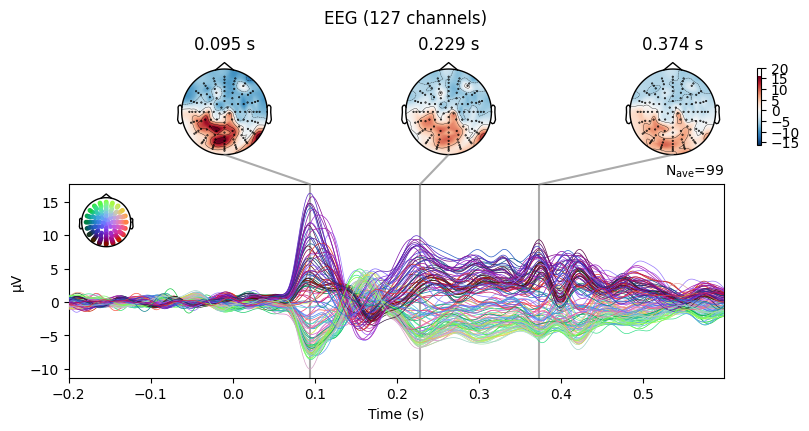

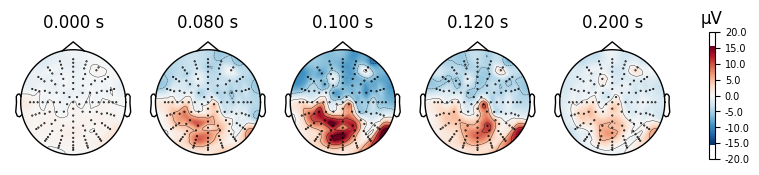

In [18]:
%matplotlib inline
epochs['face'].average().plot_joint()
_ = epochs['face'].average().plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2])

Sure enough, we see the occipital acitivity you would expect when viewing a fairly bright stimulus.

The next cell briefly simulates an ERP comparison across the button press events and the house based events on two channels averaged together.

combining channels using "mean"
combining channels using "mean"


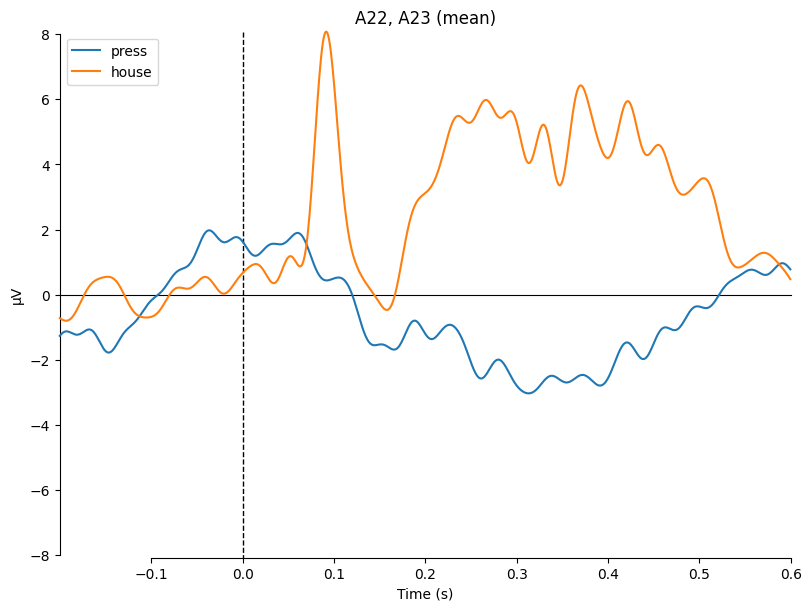

[<Figure size 800x600 with 1 Axes>]

In [20]:
%matplotlib inline
comparison = {
    'press': epochs['press'].average(),
    'house': epochs['house'].average(),
}
mne.viz.plot_compare_evokeds(comparison, combine='mean', picks=['A22', 'A23'])

Lastly, at any time once epoched, the waveform data can be saved into a dataframe or CSV for processing in other software applications such as R.

In [21]:
epochs['press'].to_data_frame()

,time,condition,epoch,A1,A2,A3,A4,A5,A6,A7,...,D24,D25,D26,D27,D28,D29,D30,D31,D32,Status
0,-0.200195,press/left,2,-13.747705,-11.875610,-7.813668,-8.645018,-6.858418,-1.398908,-0.290842,...,2.970959,7.438537,-1.258813,-4.376485,-5.232079,0.509433,1.446695,3.263036,4.239827,0.0
1,-0.199219,press/left,2,-14.501829,-12.152485,-7.738443,-8.065783,-6.094511,-0.967591,0.612493,...,3.980351,8.260483,-0.052411,-3.680820,-4.440955,1.433492,2.311743,4.031558,4.903261,0.0
2,-0.198242,press/left,2,-15.230630,-12.412138,-7.660990,-7.494222,-5.321791,-0.495312,1.552326,...,4.982262,8.969227,1.161827,-3.023394,-3.586278,2.385793,3.196326,4.826627,5.598087,0.0
3,-0.197266,press/left,2,-15.927879,-12.653657,-7.584250,-6.939330,-4.546943,0.011955,2.520299,...,5.969080,9.558437,2.365999,-2.411542,-2.678232,3.358314,4.093464,5.643415,6.322250,0.0
4,-0.196289,press/left,2,-16.586946,-12.875367,-7.510735,-6.408635,-3.776121,0.547772,3.507650,...,6.933984,10.025741,3.542266,-1.850856,-1.729019,4.342609,4.995904,6.476891,7.072613,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82815,0.595703,press/left,399,-1.813236,-1.795430,-0.880784,-2.118369,-2.503844,11.770358,5.947443,...,11.093502,6.838220,6.125123,0.631224,-0.881264,7.176860,7.741417,5.740005,14.016034,0.0
82816,0.596680,press/left,399,-2.404194,-2.338212,-1.204693,-2.348815,-2.643007,11.545109,5.824114,...,10.932926,6.525635,5.954113,0.515573,-1.393545,6.949452,7.749098,5.861715,14.314249,0.0
82817,0.597656,press/left,399,-3.052144,-2.911677,-1.579542,-2.578207,-2.747873,11.323518,5.711578,...,10.729428,6.192045,5.769462,0.412811,-1.921582,6.732174,7.752195,5.971007,14.589858,0.0
82818,0.598633,press/left,399,-3.745351,-3.507766,-2.000124,-2.803759,-2.815959,11.111861,5.611404,...,10.487105,5.840961,5.574161,0.323480,-2.452800,6.530428,7.750772,6.065303,14.837928,0.0
